<a href="https://colab.research.google.com/github/shivendrashahi/NLP_Word_Embeddings/blob/main/Shivendra_Shahi_Mini_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction to NLP

* Data comes in many different forms: time stamps, sensor readings, images, categorical labels, and so much more. But text is still some of the most valuable data out there for those who know how to use it.

* In this notebook about Natural Language Processing (NLP), you will use the leading NLP library (spaCy) to take on some of the most important tasks in working with text.

  By the end, you will be able to use spaCy for:

1. Basic text processing and pattern matching

2. Building machine learning models with text
3. Representing text with word embeddings that numerically capture the meaning of words and documents

* To get the most out of this course, you'll need some experience with machine learning. If you don't have experience with scikit-learn, check out Intro to Machine Learning and Intermediate Machine Learning to learn the fundamentals.

## NLP with spaCy

* spaCy is the leading library for NLP, and it has quickly become one of the most popular Python frameworks. Most people find it intuitive, and it has excellent documentation.

* spaCy relies on models that are language-specific and come in different sizes. You can load a spaCy model with spacy.load.

* For example, here's how you would load the English language model.

In [ ]:
import spacy
nlp = spacy.load('en')

With the model loaded, you can process text like this:

In [ ]:
doc = nlp("Tea is healthy and calming, don't you think?")

There's a lot you can do with the doc object you just created.

## Tokenizing

This returns a document object that contains tokens. A token is a unit of text in the document, such as individual words and punctuation. SpaCy splits contractions like "don't" into two tokens, "do" and "n't". You can see the tokens by iterating through the document.

In [ ]:
for token in doc:
    print(token)

Tea
is
healthy
and
calming
,
do
n't
you
think
?


Iterating through a document gives you token objects. Each of these tokens comes with additional information. In most cases, the important ones are token.lemma_ and token.is_stop.

## Text Processing

* There are a few types of preprocessing to improve how we model with words. The first is "lemmatizing." The "lemma" of a word is its base form. For example, "walk" is the lemma of the word "walking". So, when you lemmatize the word walking, you would convert it to walk.

* It's also common to remove stopwords. Stopwords are words that occur frequently in the language and don't contain much information. English stopwords include "the", "is", "and", "but", "not".

* With a spaCy token, token.lemma_ returns the lemma, while token.is_stop returns a boolean True if the token is a stopword (and False otherwise).

In [ ]:
print(f"Token \t\tLemma \t\tStopword".format('Token', 'Lemma', 'Stopword'))
print("-"*40)
for token in doc:
    print(f"{str(token)}\t\t{token.lemma_}\t\t{token.is_stop}")

Token 		Lemma 		Stopword
----------------------------------------
Tea		tea		False
is		be		True
healthy		healthy		False
and		and		True
calming		calm		False
,		,		False
do		do		True
n't		not		True
you		-PRON-		True
think		think		False
?		?		False


Why are lemmas and identifying stopwords important? Language data has a lot of noise mixed in with informative content. In the sentence above, the important words are tea, healthy and calming. Removing stop words might help the predictive model focus on relevant words. Lemmatizing similarly helps by combining multiple forms of the same word into one base form ("calming", "calms", "calmed" would all change to "calm").

However, lemmatizing and dropping stopwords might result in your models performing worse. So you should treat this preprocessing as part of your hyperparameter optimization process.

## Pattern Matching

* Another common NLP task is matching tokens or phrases within chunks of text or whole documents. You can do pattern matching with regular expressions, but spaCy's matching capabilities tend to be easier to use.

* To match individual tokens, you create a Matcher. When you want to match a list of terms, it's easier and more efficient to use PhraseMatcher. For example, if you want to find where different smartphone models show up in some text, you can create patterns for the model names of interest. First you create the PhraseMatcher itself.

In [ ]:
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

The matcher is created using the vocabulary of your model. Here we're using the small English model you loaded earlier. Setting attr='LOWER' will match the phrases on lowercased text. This provides case insensitive matching.

Next you create a list of terms to match in the text. The phrase matcher needs the patterns as document objects. The easiest way to get these is with a list comprehension using the nlp model.

In [ ]:
terms = ['Galaxy Note', 'iPhone 11', 'iPhone XS', 'Google Pixel']
patterns = [nlp(text) for text in terms]
matcher.add("TerminologyList", patterns)

Then you create a document from the text to search and use the phrase matcher to find where the terms occur in the text.

In [ ]:
# Borrowed from https://daringfireball.net/linked/2019/09/21/patel-11-pro
text_doc = nlp("Glowing review overall, and some really interesting side-by-side "
               "photography tests pitting the iPhone 11 Pro against the "
               "Galaxy Note 10 Plus and last year’s iPhone XS and Google Pixel 3.") 
matches = matcher(text_doc)
print(matches)

[(3766102292120407359, 17, 19), (3766102292120407359, 22, 24), (3766102292120407359, 30, 32), (3766102292120407359, 33, 35)]


The matches here are a tuple of the match id and the positions of the start and end of the phrase.

In [ ]:
match_id, start, end = matches[0]
print(nlp.vocab.strings[match_id], text_doc[start:end])

TerminologyList iPhone 11


# 2. Text Classification with SpaCy

* A common task in NLP is text classification. This is "classification" in the conventional machine learning sense, and it is applied to text. Examples include spam detection, sentiment analysis, and tagging customer queries.

* In this tutorial, you'll learn text classification with spaCy. The classifier will detect spam messages, a common functionality in most email clients.

## Bag of Words

* Machine learning models don't learn from raw text data. Instead, you need to convert the text to something numeric.

* The simplest common representation is a variation of one-hot encoding. You represent each document as a vector of term frequencies for each term in the vocabulary. The vocabulary is built from all the tokens (terms) in the corpus (the collection of documents).

* As an example, take the sentences "Tea is life. Tea is love." and "Tea is healthy, calming, and delicious." as our corpus. The vocabulary then is {"tea", "is", "life", "love", "healthy", "calming", "and", "delicious"} (ignoring punctuation).

* For each document, count up how many times a term occurs, and place that count in the appropriate element of a vector. The first sentence has "tea" twice and that is the first position in our vocabulary, so we put the number 2 in the first element of the vector. Our sentences as vectors then look like

  v1 = [2 2 1 1 0 0 0 0]

  v2 = [1 1 0 0 1 1 1 1]
 
* This is called the bag of words representation. You can see that documents with similar terms will have similar vectors. Vocabularies frequently have tens of thousands of terms, so these vectors can be very large.

* Another common representation is TF-IDF (Term Frequency - Inverse Document Frequency). TF-IDF is similar to bag of words except that each term count is scaled by the term's frequency in the corpus. Using TF-IDF can potentially improve your models. You won't need it here. Feel free to look it up though!

## Building a Bag of Words model

* Once you have your documents in a bag of words representation, you can use those vectors as input to any machine learning model. spaCy handles the bag of words conversion and building a simple linear model for you with the TextCategorizer class.

* The TextCategorizer is a spaCy pipe. Pipes are classes for processing and transforming tokens. When you create a spaCy model with nlp = spacy.load('en_core_web_sm'), there are default pipes that perform part of speech tagging, entity recognition, and other transformations. When you run text through a model doc = nlp("Some text here"), the output of the pipes are attached to the tokens in the doc object. The lemmas for token.lemma_ come from one of these pipes.

* You can remove or add pipes to models. What we'll do here is create an empty model without any pipes (other than a tokenizer, since all models always have a tokenizer). Then, we'll create a TextCategorizer pipe and add it to the empty model.

In [ ]:
import spacy

# Create an empty model
nlp = spacy.blank("en")

# Create the TextCategorizer with exclusive classes and "bow" architecture
textcat = nlp.create_pipe(
              "textcat",
              config={
                "exclusive_classes": True,
                "architecture": "bow"})

# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)

* Since the classes are either ham or spam, we set "exclusive_classes" to True. We've also configured it with the bag of words ("bow") architecture. spaCy provides a convolutional neural network architecture as well, but it's more complex than you need for now.

* Next we'll add the labels to the model. Here "ham" are for the real messages, "spam" are spam messages.

In [ ]:
# Add labels to text classifier
textcat.add_label("ham")
textcat.add_label("spam")

## Training a Text Categorizer Model

* Next, you'll convert the labels in the data to the form TextCategorizer requires. For each document, you'll create a dictionary of boolean values for each class.

* For example, if a text is "ham", we need a dictionary {'ham': True, 'spam': False}. The model is looking for these labels inside another dictionary with the key 'cats'.

In [ ]:
train_texts = spam['text'].values
train_labels = [{'cats': {'ham': label == 'ham',
                          'spam': label == 'spam'}} 
                for label in spam['label']]

Then we combine the texts and labels into a single list.

In [ ]:
train_data = list(zip(train_texts, train_labels))
train_data[:3]

Now you are ready to train the model. First, create an optimizer using nlp.begin_training(). spaCy uses this optimizer to update the model. In general it's more efficient to train models in small batches. spaCy provides the minibatch function that returns a generator yielding minibatches for training. Finally, the minibatches are split into texts and labels, then used with nlp.update to update the model's parameters.

In [ ]:
from spacy.util import minibatch

spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

# Create the batch generator with batch size = 8
batches = minibatch(train_data, size=8)
# Iterate through minibatches
for batch in batches:
    # Each batch is a list of (text, label) but we need to
    # send separate lists for texts and labels to update().
    # This is a quick way to split a list of tuples into lists
    texts, labels = zip(*batch)
    nlp.update(texts, labels, sgd=optimizer)

This is just one training loop (or epoch) through the data. The model will typically need multiple epochs. Use another loop for more epochs, and optionally re-shuffle the training data at the begining of each loop.

In [ ]:
import random

random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(10):
    random.shuffle(train_data)
    # Create the batch generator with batch size = 8
    batches = minibatch(train_data, size=8)
    # Iterate through minibatches
    for batch in batches:
        # Each batch is a list of (text, label) but we need to
        # send separate lists for texts and labels to update().
        # This is a quick way to split a list of tuples into lists
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd=optimizer, losses=losses)
    print(losses)

## Making Predictions

Now that you have a trained model, you can make predictions with the predict() method. The input text needs to be tokenized with nlp.tokenizer. Then you pass the tokens to the predict method which returns scores. The scores are the probability the input text belongs to the classes.

In [ ]:
texts = ["Are you ready for the tea party????? It's gonna be wild",
         "URGENT Reply to this message for GUARANTEED FREE TEA" ]
docs = [nlp.tokenizer(text) for text in texts]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)

The scores are used to predict a single class or label by choosing the label with the highest probability. You get the index of the highest probability with scores.argmax, then use the index to get the label string from textcat.labels.

In [ ]:
# From the scores, find the label with the highest score/probability
predicted_labels = scores.argmax(axis=1)
print([textcat.labels[label] for label in predicted_labels])

Evaluating the model is straightforward once you have the predictions. To measure the accuracy, calculate how many correct predictions are made on some test data, divided by the total number of predictions.

# Word Embeddings

* You know at this point that machine learning on text requires that you first represent the text numerically. So far, you've done this with bag of words representations. But you can usually do better with word embeddings.

* Word embeddings (also called word vectors) represent each word numerically in such a way that the vector corresponds to how that word is used or what it means. Vector encodings are learned by considering the context in which the words appear. Words that appear in similar contexts will have similar vectors. For example, vectors for "leopard", "lion", and "tiger" will be close together, while they'll be far away from "planet" and "castle".

* Even cooler, relations between words can be examined with mathematical operations. Subtracting the vectors for "man" and "woman" will return another vector. If you add that to the vector for "king" the result is close to the vector for "queen."

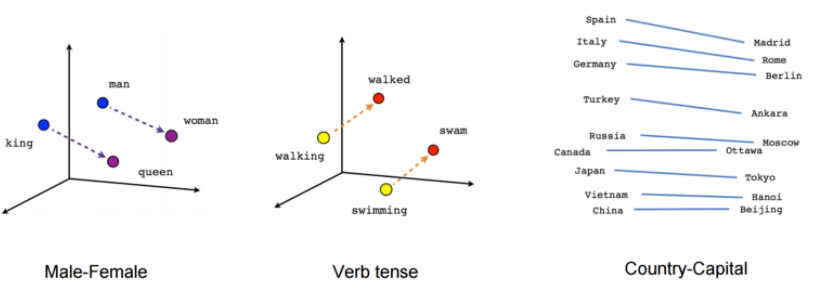

* These vectors can be used as features for machine learning models. Word vectors will typically improve the performance of your models above bag of words encoding. spaCy provides embeddings learned from a model called Word2Vec. You can access them by loading a large language model like en_core_web_lg. Then they will be available on tokens from the .vector attribute.

In [ ]:
import numpy as np
import spacy

# Need to load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')

In [ ]:
# Disabling other pipes because we don't need them and it'll speed up this part a bit
text = "These vectors can be used as features for machine learning models."
with nlp.disable_pipes():
    vectors = np.array([token.vector for token in  nlp(text)])

* These are 300-dimensional vectors, with one vector for each word. However, we only have document-level labels and our models won't be able to use the word-level embeddings. So, you need a vector representation for the entire document.

* There are many ways to combine all the word vectors into a single document vector we can use for model training. A simple and surprisingly effective approach is simply averaging the vectors for each word in the document. Then, you can use these document vectors for modeling.

* spaCy calculates the average document vector which you can get with doc.vector. Here is an example loading the spam data and converting it to document vectors.

In [ ]:
import pandas as pd

# Loading the spam data
# ham is the label for non-spam messages
spam = pd.read_csv('../input/nlp-course/spam.csv')

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in spam.text])
    
doc_vectors.shape

## Classification Models

With the document vectors, you can train scikit-learn models, xgboost models, or any other standard approach to modeling.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, spam.label,
                                                    test_size=0.1, random_state=1)

Here is an example using support vector machines (SVMs). Scikit-learn provides an SVM classifier LinearSVC. This works similar to other scikit-learn models.

In [ ]:
from sklearn.svm import LinearSVC

# Set dual=False to speed up training, and it's not needed
svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train, y_train)
print(f"Accuracy: {svc.score(X_test, y_test) * 100:.3f}%", )

## Document Similarity

* Documents with similar content generally have similar vectors. So you can find similar documents by measuring the similarity between the vectors. A common metric for this is the cosine similarity which measures the angle between two vectors,  a  and  b .

  cosθ=(a⋅b)/(|a||b|)
 
* This is the dot product of  a  and  b , divided by the magnitudes of each vector. The cosine similarity can vary between -1 and 1, corresponding complete opposite to perfect similarity, respectively. To calculate it, you can use the metric from scikit-learn or write your own function.

In [ ]:
def cosine_similarity(a, b):
    return a.dot(b)/np.sqrt(a.dot(a) * b.dot(b))

In [ ]:
a = nlp("REPLY NOW FOR FREE TEA").vector
b = nlp("According to legend, Emperor Shen Nung discovered tea when leaves from a wild tree blew into his pot of boiling water.").vector
cosine_similarity(a, b)

# **MULTILINGUAL EMBEDDINGS**


## Multilingual Embeddings - 1. Cross-lingual Sentence Similarity

In this notebook, we're going to explore some more practical applications. Let's start with cross-lingual sentence similarity. As we've seen before, pretrained word embeddings can help us determine the semantic similarity between two sentences. However, when you're working with monolingual embeddings, you can only compute the similarity in meaning between two sentences in the same language. This is a downside. In applications like search engines or question answering systems, it's often practical if you can search documents or questions and answers in more than one language.

## Data

The training and test set for this challenge consist of question pairs with duplicate or non-duplicate questions. Because the questions are all in English, we take the first 1,000 questions from the training set and use Google Translate to translate the second question in the pair from English to French. Obviously, the translations are not always perfect, but for our purposes they are good enough. This gives us 1,000 data items, each with two English questions (question1_en and question2_en), the French translation of the second English question (question2_fr) and an indicate of whether the two questions are the same or not (is_duplicate).

In [5]:
%matplotlib inline
import pandas as pd

questions = pd.read_csv("/content/drive/MyDrive/NLP_Data/multilingual_embeddings/questions.csv")
questions.head()

,id,question1_en,question2_en,question2_fr,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,Quel est le guide étape par étape pour investi...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,Que se passerait-il si le gouvernement indien ...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,Comment augmenter la vitesse d'Internet en pir...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,Trouvez le reste lorsque [math] 23 ^ {24} [/ m...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,Quel poisson survivrait dans l'eau salée?,0


## Embeddings

In this step we are going to download embeddings that already share the same vector space. These embeddings, and the code to obtain them, are provided by the MUSE library from Facebook Research.

In [18]:
from gensim.models import KeyedVectors

fr_embeddings = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/NLP_Data/wiki.fr.vec")
en_embeddings = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/NLP_Data/wiki.en.vec")

## Smooth Inverse Frequency

It calculates the embedding of a sentence by taking the weighted sum of its word embeddings and then removing the first principal component from a set of sentence embeddings. Let's reuse that implementation here.

In [11]:
pip install wordfreq


     |████████████████████████████████| 32.8MB 127kB/s 
     |████████████████████████████████| 5.0MB 44.0MB/s 
     |████████████████████████████████| 276kB 40.7MB/s 
  Created wheel for wordfreq: filename=wordfreq-2.3.2-cp36-none-any.whl size=32817239 sha256=f70de50246b7d4d1690d427a695b7b15dfc00f2e6db7af4c8cd7e790d160652e
  Stored in directory: /root/.cache/pip/wheels/8d/ba/84/ba6be76208bd2c2124b6586f7967fb87e9f9fb4b4827e5e2c9
  Created wheel for langcodes: filename=langcodes-2.1.0-cp36-none-any.whl size=5068034 sha256=8903cc5551bbe6a8e540adb9fd9ca85bc21b8721cd7cb8fb00cc0e25e1060cbf
  Stored in directory: /root/.cache/pip/wheels/f7/aa/f5/285652c17bb68a5f6d30bdfeebb517d210cabe18268fcb80b5
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp36-cp36m-linux_x86_64.whl size=862229 sha256=32d71a895338709358c8f64e972f04384043844277d3b6634dfd2c6a2355a05c
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141aaff1f9df810905a13fc75d57
Successfully built wor

In [19]:
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX


def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    question_embeddings = remove_first_principal_component(np.array(question_embeddings)) 
    return question_embeddings

## Question similarity

In our first experiment, we'd like to find out whether the embeddings of two duplicate questions are indeed more similar than the embeddings of non-duplicate sentences. To this goal, we compute two types of similarity. First we take a look at a simple baseline, which calculcates the similarity between two questions as the cosine between their tf-idf weighted token vectors. We expect in particular that the tf-idf token vectors of two English duplicate questions should display a higher cosine similarity than non-duplicate ones. Moreover, these tf-idf vectors may also tell us whether an English and a French question are duplicates, simply because duplicate questions in different languages often still share content words, such as proper nouns.

Second, we calculate the similarities on the basis of the sentence embeddings obtained with Smooth Inverse Frequency. For the English question pairs, the original word embeddings should be perfectly comparable. For the English-French question pairs, the word embeddings have been projected into a shared multilingual space by the makers of the MUSE library. The resulting sentence embeddings should therefore also be more similar for duplicate questions.

In [23]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_en = TfidfVectorizer()
tfidf_en.fit(questions["question1_en"] + questions["question2_en"])

tfidf_enfr = TfidfVectorizer()
tfidf_enfr.fit(questions["question1_en"] + questions["question2_fr"])

questions1_all_en_emb = compute_sentence_embeddings(questions["question1_en"], en_embeddings, "en")
questions2_all_en_emb = compute_sentence_embeddings(questions["question2_en"], fr_embeddings, "en")
questions2_all_fr_emb = compute_sentence_embeddings(questions["question2_fr"], fr_embeddings, "fr")

questions1_all_en_tfidf_en = tfidf_en.transform(questions["question1_en"])
questions2_all_en_tfidf_en = tfidf_en.transform(questions["question2_en"])

questions1_all_en_tfidf_enfr = tfidf_enfr.transform(questions["question1_en"])
questions2_all_fr_tfidf_enfr = tfidf_enfr.transform(questions["question2_fr"])

questions["tfidf_en_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -2))[0,0]
                            for q1, q2 in zip(questions1_all_en_tfidf_en, questions2_all_en_tfidf_en)]

questions["tfidf_enfr_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -2))[0,0]
                               for q1, q2 in zip(questions1_all_en_tfidf_enfr, questions2_all_fr_tfidf_enfr)]

questions["emb_en_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -1))[0,0]
                        for q1, q2 in zip(questions1_all_en_emb, questions2_all_en_emb)]

questions["emb_enfr_sim"] = [cosine_similarity(q1.reshape(1, -1), q2.reshape(1, -1))[0,0]
                        for q1, q2 in zip(questions1_all_en_emb, questions2_all_fr_emb)]

The statistics and box plots below confirm our hypotheses:

* The tf-idf weighted token vectors of English duplicate questions are much more similar than those of non-duplicate questions, on average (top left).

* The tf-idf weighted token vectors of French-English duplicate questions are sometimes more similar than those of non-duplicate questions, but not very often so. The median similarity of 0 for both duplicate and non-duplicate question pairs suggests that the tokens in the French and English questions overlap very rarely. We therefore need multilingual word embeddings to compute cross-lingual question similarity more reliably (top right).

* The monolingual embedding similarity of English duplicate questions is much higher (mean 0.37) than that of non-duplicate questions (mean 0.27).

* The cross-lingual embedding similarity of English-French duplicate questions is much higher (mean 0.45) than that of non-duplicate questions (mean 0.34). This indicates that multilingual embeddings can offer a effective way of computing the similarity between two sentences in different languages.

Statistics for duplicate questions
               id  is_duplicate  ...  emb_en_sim  emb_enfr_sim
count  380.000000         380.0  ...  380.000000    380.000000
mean   503.355263           1.0  ...    0.366502      0.452100
std    286.159056           0.0  ...    0.129475      0.147308
min      5.000000           1.0  ...   -0.013472     -0.029722
25%    254.500000           1.0  ...    0.278676      0.361294
50%    504.000000           1.0  ...    0.374021      0.459481
75%    752.750000           1.0  ...    0.446015      0.552974
max    998.000000           1.0  ...    0.720917      0.812401

[8 rows x 6 columns]
Statistics for non-duplicate questions
               id  is_duplicate  ...  emb_en_sim  emb_enfr_sim
count  620.000000         620.0  ...  620.000000    620.000000
mean   497.137097           0.0  ...    0.272888      0.339714
std    290.642888           0.0  ...    0.178574      0.197365
min      0.000000           0.0  ...   -0.157621     -0.214311
25%    244.000000     

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ece5facc0>,
      dtype=object)

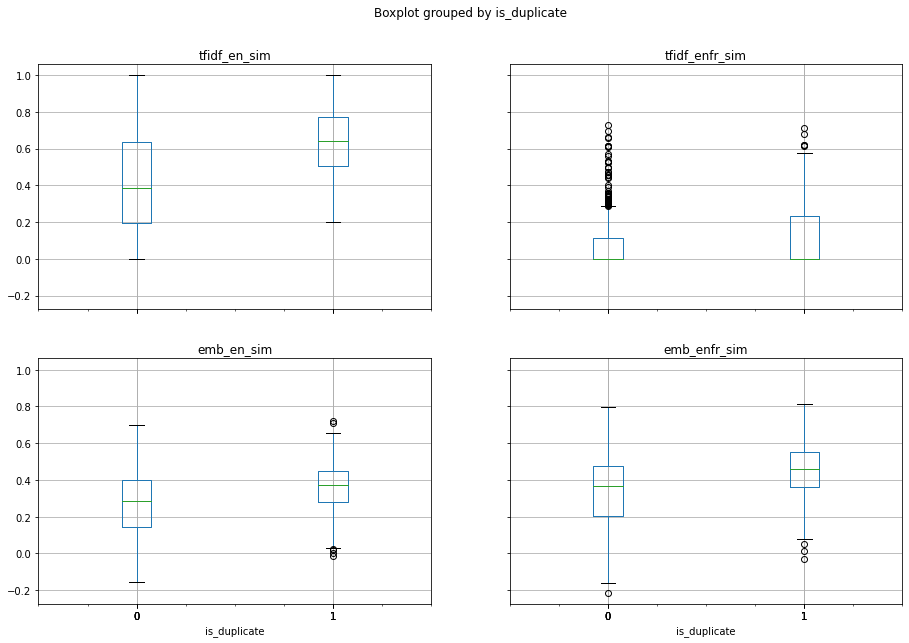

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Descriptive statistics
print("Statistics for duplicate questions")
print(questions.loc[questions["is_duplicate"] == 1].describe())
print("Statistics for non-duplicate questions")
print(questions.loc[questions["is_duplicate"] == 0].describe())

# Figure
plt.rcParams['figure.figsize'] = (15,10)
columns = ["tfidf_en_sim", "tfidf_enfr_sim", "emb_en_sim", "emb_enfr_sim"]
questions.boxplot(column=columns, by="is_duplicate", layout=(2,2))

## Question retrieval

Now suppose we're building a search engine of question and answers. We would like to match a user question to existing questions in our database, irrespective of their language, English or French. Let's simulate this setup by selecting from our data the 380 French-English duplicate question pairs. For each English question, we would like to identify the most related question from all 380 French questions. If we do this correctly, this French question should have the same index of the English question, because they belong to the same pair.

We again start by investigating a simple baseline that identifies from the 380 French questions the question with the most similar tf-idf weighted token vector. It gives us the correct question in 34% of the cases, thanks to the shared words between the two languages (as in What does manipulation mean? = Que signifie la manipulation?) and the presence of proper nouns (as in Who are the Rohingya Muslims? = Qui sont les Rohingya?).

In [29]:
import numpy as np

duplicates_en = list(questions["question1_en"].loc[questions["is_duplicate"] == 1])
duplicates_fr = list(questions["question2_fr"].loc[questions["is_duplicate"] == 1])

duplicates_en_tfidf = tfidf_enfr.transform(duplicates_en)
duplicates_fr_tfidf = tfidf_enfr.transform(duplicates_fr)

similarity_matrix = cosine_similarity(duplicates_en_tfidf, duplicates_fr_tfidf)

def evaluate_similarity_matrix(similarity_matrix, verbose=1): 
    correct, total = 0, 0
    for (idx, row) in enumerate(similarity_matrix): 
        matching_index = np.argmax(row)
        if verbose == 1:
            print(idx, duplicates_en[idx])
            print(matching_index, duplicates_fr[matching_index])
        if idx == matching_index:
            correct += 1 
        elif verbose == 1:
            print("=>", duplicates_fr[idx])
        
        if verbose == 1: 
            print("--")
        total += 1
    return correct/total

acc_baseline = evaluate_similarity_matrix(similarity_matrix)
print("Baseline accuracy:", acc_baseline)

0 Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
87 Dans "A Raisin in the Sun", pourquoi Walter et Beneatha se disputent-ils?
=> Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
--
1 How can I be a good geologist?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
=> Que dois-je faire pour être un grand géologue?
--
2 How do I read and find my YouTube comments?
216 Comment gagner de l'argent via YouTube?
=> Comment puis-je voir tous mes commentaires sur Youtube?
--
3 What can make Physics easy to learn?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
=> Comment pouvez-vous rendre la physique facile à apprendre?
--
4 What was your first sexual experience like?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
=> Quelle a été votre prem

Multilingual embeddings should do better than that. We again use Smooth Inverse Frequency to obtain the sentence embeddings for the French and English questions and now select the French question with the highest embedding similarity with the English query. This performs much better: it identifies the duplicate French question in 71% of the cases, even when the questions do not share a single word (as in How should I start meditating? = Comment devrais-je commencer à méditer et quand?).

In [30]:
duplicates_en_emb = compute_sentence_embeddings(duplicates_en, en_embeddings, "en")
duplicates_fr_emb = compute_sentence_embeddings(duplicates_fr, fr_embeddings, "fr")

similarity_matrix_emb = cosine_similarity(duplicates_en_emb, duplicates_fr_emb)
acc_embedding = evaluate_similarity_matrix(similarity_matrix_emb)
print("Embedding accuracy:", acc_embedding)

0 Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
0 Je suis un triple Capricorne (Soleil, Lune et ascendant en Capricorne) Qu'est-ce que cela dit de moi?
--
1 How can I be a good geologist?
1 Que dois-je faire pour être un grand géologue?
--
2 How do I read and find my YouTube comments?
2 Comment puis-je voir tous mes commentaires sur Youtube?
--
3 What can make Physics easy to learn?
3 Comment pouvez-vous rendre la physique facile à apprendre?
--
4 What was your first sexual experience like?
4 Quelle a été votre première expérience sexuelle?
--
5 What would a Trump presidency mean for current international master’s students on an F1 visa?
5 Comment une présidence Trump affectera-t-elle les étudiants actuellement aux États-Unis ou prévoit-elle d'étudier aux États-Unis?
--
6 What does manipulation mean?
6 Que signifie la manipulation?
--
7 Why are so many Quora users posting questions that are readily answered on Google?
7 Pourquoi les gens posent-

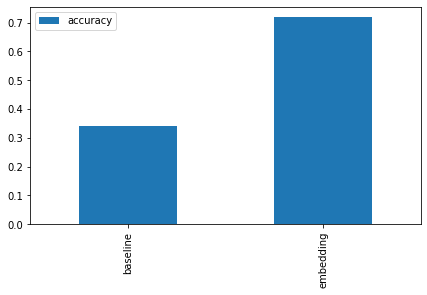

In [31]:
df = pd.DataFrame({"accuracy": {"baseline": acc_baseline, "embedding": acc_embedding}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")

## Conclusions

Our simple experiments show multilingual word embeddings can effectively model the semantic similarity between two sentences in different languages. This allows us to build cross-lingual search engines or question-answering applications. Still, multilingual embeddings can do more than that: they can also help us transfer a trained NLP model from one language to the other. That's the topic of our following  on Transfer Learning.

## Multilingual Embeddings - 3. Transfer Learning

One of the most promising applications of multilingual word embeddings is cross-lingual transfer learning. Suppose you would like to train an NLP model in several languages, but you only have training data in one language. Collecting new training data for each of your target languages can be expensive, and translating every text you'd like to process is rather cumbersome. With cross-lingual word embeddings, however, you can transfer your model from one language to the other very efficiently.

**Embeddings**

In [33]:
import numpy as np

def load_vectors(embedding_file_path):
    print("Loading vectors from", embedding_file_path)
    embeddings = []
    word2id = {}
    with open(embedding_file_path, 'r', encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, emb = line.rstrip().split(' ', 1)
            emb = np.fromstring(emb, sep=' ')
            assert word not in word2id, 'word found twice'
            embeddings.append(emb)
            word2id[word] = len(word2id)

    embeddings = np.vstack(embeddings)
    return embeddings, word2id

embeddings_en, embedding_word2id_en = load_vectors("/content/drive/MyDrive/NLP_Data/wiki.en.vec")
embeddings_fr, embedding_word2id_fr = load_vectors("/content/drive/MyDrive/NLP_Data/wiki.fr.vec")

Loading vectors from /content/drive/MyDrive/NLP_Data/wiki.en.vec
Loading vectors from /content/drive/MyDrive/NLP_Data/wiki.fr.vec


## Data Preprocessing

We'll use Keras to train a simple model for sentiment analysis. This model will tell us whether a text contains a positive or a negative opinion. As our training and test data, we'll take the popular IMDB dataset of movie reviews.

After downloading the data, we apply the traditional preprocessing steps. We'll work with a vocabulary of 10,000 words, cut off long texts after 500 words and pad all shorter texts to that same number of tokens.

In [34]:
from keras.datasets import imdb
from keras.preprocessing import sequence

VOCABULARY_SIZE = 10000
INDEX_FROM = 3
START_INDEX = 1
OOV_INDEX = 2
EMBEDDING_DIM = 300
SEQ_LENGTH = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=VOCABULARY_SIZE,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=START_INDEX,
                                                      oov_char=OOV_INDEX,
                                                      index_from=INDEX_FROM)

X_train = sequence.pad_sequences(X_train, maxlen=SEQ_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=SEQ_LENGTH)

17465344/17464789 [==============================] - 0s 0us/step


## Pre-trained word embeddings

To be able to transfer our model between languages, its embedding layer needs to project the words into a multilingual vector space. We therefore initialize it with (a subset of) the multilingual word embeddings we downloaded earlier.

First, we need to find out what words the indices in the preprocessed IMDB data stand for. Then we create an embedding matrix where each row contains the embedding of the word indexed by its row number.

In [35]:
def create_embedding_matrix(target_word2id, embedding_word2id, embeddings, num_rows, num_columns):
    embedding_matrix = np.zeros((num_rows, num_columns))
    for word, i in target_word2id.items():
        if i >= num_rows:
            continue
        if word in embedding_word2id: 
            embedding_matrix[i] = embeddings[embedding_word2id[word]]
    return embedding_matrix

In [36]:
word2id_en = imdb.get_word_index()
word2id_en = {k:(v+INDEX_FROM) for k,v in word2id_en.items()}
word2id_en["<PAD>"] = 0
word2id_en["<START>"] = START_INDEX
word2id_en["<UNK>"] = OOV_INDEX

embedding_matrix_en = create_embedding_matrix(word2id_en, embedding_word2id_en, 
                                              embeddings_en, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)

1646592/1641221 [==============================] - 0s 0us/step


## Train our Model

Now it's time to train our model. We'll work with the basic convolutional network. Its single-value output ranges from 0 to 1 and indicates whether a text is more positive (1) or negative (0).

In [37]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, input_length=SEQ_LENGTH, weights=[embedding_matrix_en], trainable=False))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3000600   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               2000250   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 5,029,933
Trainable params: 2,029,333
Non-trainable params: 3,000,600
______________________________________

Next, we'll train this model with some standard settings. We'll use a batch size of 64, and stop iterating over the training data when the validation loss does not improve anymore. We'll end up with an accuracy of around 86%.

In [38]:
NUM_EPOCHS=20
BATCH_SIZE=64

earlystop = EarlyStopping(monitor='val_loss', patience=2)

model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlystop])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
391/391 [==============================] - 99s 253ms/step - loss: 0.5123 - accuracy: 0.7145 - val_loss: 0.3561 - val_accuracy: 0.8428
Epoch 2/20
391/391 [==============================] - 98s 251ms/step - loss: 0.3160 - accuracy: 0.8643 - val_loss: 0.3076 - val_accuracy: 0.8687
Epoch 3/20
391/391 [==============================] - 98s 251ms/step - loss: 0.2494 - accuracy: 0.8980 - val_loss: 0.3114 - val_accuracy: 0.8686
Epoch 4/20
782/782 [==============================] - 26s 33ms/step - loss: 0.3756 - accuracy: 0.8539
Accuracy: 85.39%



A few sanity checks will show the model does what it's supposed to do: a positive English sentence such as "it was a great movie" gets a score close to 1, while a negative English sentence such as "it was a horrible movie" gets a score closer to 0.

In [39]:
test_texts = ["it was a great movie".split(), "it was a horrible movie".split()]
test_vectors = [[word2id_en.get(w, OOV_INDEX) for w in text] for text in test_texts]

padded_test_vectors = sequence.pad_sequences(test_vectors, maxlen=SEQ_LENGTH)

model.predict(padded_test_vectors)

array([[0.82038915],
       [0.31568253]], dtype=float32)

## Transferring our Model

Obviously the above model cannot be used to classify French texts. Most French words are not present in our English vocabulary, and even if they were, it's questionable whether their English embedding would contain the correct information. To transfer our model from English to French, we need to replace its English embedding layer by a French embedding layer.

We're again going to work with a vocabulary of 10,000 words. Unfortunately, we don't have a relevant set of French texts to fit this vocabulary on. Therefore we'll install Luminoso Insight's useful wordfreq library. This library contains word frequency information for many Western languages. In particular, top_n_list will give us the most frequent n words for a language, as measured in a set of large corpora. For example, it tells us the most frequent three English words are the, of and to, while the most frequent French words are de, la and le.

In [40]:
from wordfreq import top_n_list

print(top_n_list('en', 10))
print(top_n_list('fr', 10))

['the', 'of', 'to', 'and', 'a', 'in', 'i', 'is', 'that', 'for']
['de', 'la', 'le', 'et', 'l', 'à', 'les', 'est', 'des', 'en']



We'll construct our vocabulary from the most frequent 10,000 French words, and use it to create a French embedding matrix.

In [41]:
word2id_fr = {word: idx+INDEX_FROM for idx, word in enumerate(top_n_list('fr', VOCABULARY_SIZE))}
word2id_fr["<PAD>"] = 0
word2id_fr["<START>"] = START_INDEX
word2id_fr["<UNK>"] = OOV_INDEX

In [42]:

embedding_matrix_fr = create_embedding_matrix(word2id_fr, embedding_word2id_fr, 
                                              embeddings_fr, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)


Next, we're going to replace the weights of the original embedding layer in our model by this new French embedding matrix.

In [43]:
model.layers[0].set_weights([embedding_matrix_fr])

And lo and behold, the model we just trained on English texts can now suddenly take French texts as input and classify them correctly.

In [44]:
test_texts_fr = ["c était un film merveilleux".split(), "c était un film horrible".split()]
test_vectors_fr = [[word2id_fr.get(w, OOV_INDEX) for w in text] for text in test_texts_fr]

padded_test_vectors_fr = sequence.pad_sequences(test_vectors_fr, maxlen=SEQ_LENGTH)

model.predict(padded_test_vectors_fr)

array([[0.89714 ],
       [0.496477]], dtype=float32)

## Conclusion

Multilingual word embeddings offer us a simple and efficient way of transferring a model from one language to the other. This comes in handy when you need to apply your model to several languages, but you only have training data in one of them.

Needless to say, transferring a model like this is not without its problems. After all, two different languages don't just have different vocabularies. They can also display variation in word order, etc. This can be problematic for models such as recurrent neural networks, but also for convolutional neural networks, which take the n-grams in a text as their input.

When the two languages are reasonably close in linguistic terms, you should be able to get decent performance from transferred model. However, it's very likely a model that has been trained on data in the same language, will likely do better.